# Automating Registration of Eye Scans

In [1]:
import cv2
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
import numpy as np
from skimage.transform import warp_polar, rotate, rescale

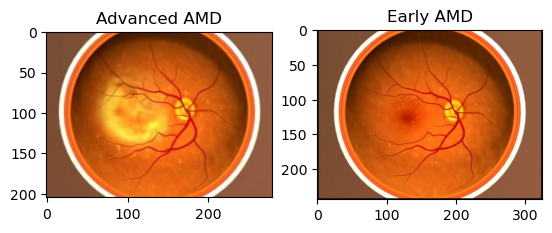

In [2]:
early_AMD = cv2.imread("./images/earlyAMD.jpg")
early_AMD = cv2.cvtColor(early_AMD, cv2.COLOR_BGR2RGB)
advanced_AMD = cv2.imread("./images/advancedAMD.jpg")
advanced_AMD = cv2.cvtColor(advanced_AMD, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(advanced_AMD)
axs[0].set_title('Advanced AMD')
axs[1].imshow(early_AMD)
axs[1].set_title('Early AMD')
plt.show()

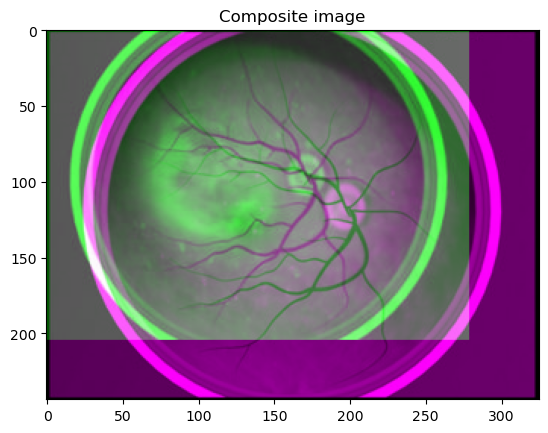

In [3]:
early_AMD_gray = cv2.cvtColor(early_AMD, cv2.COLOR_RGB2GRAY)
advanced_AMD_gray = cv2.cvtColor(advanced_AMD, cv2.COLOR_RGB2GRAY)

stacked_AMD = np.dstack((early_AMD_gray,
                        np.pad(advanced_AMD_gray, pad_width=((0, early_AMD.shape[0] - advanced_AMD_gray.shape[0]), (0, early_AMD.shape[1] - advanced_AMD_gray.shape[1])), mode='constant', constant_values=0),
                        early_AMD_gray))

plt.imshow(stacked_AMD)
plt.title("Composite image")
plt.show()

We can use [phase_cross_correlation()](https://scikit-image.org/docs/stable/api/skimage.registration.html#skimage.registration.phase_cross_correlation) to estimate the translation, rotation and scaling offset.

First, let's [recover rotation and scaling differences](https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_rotation.html#recover-rotation-and-scaling-differences-with-log-polar-transform) with log-polar transform.

In [4]:
# radius must be large enough to capture useful info in larger image
radius = 1500

early_AMD_polar = warp_polar(early_AMD, radius=radius, scaling='log', channel_axis=-1)
advanced_AMD_polar = warp_polar(advanced_AMD, radius=radius, scaling='log', channel_axis=-1)

# setting `upsample_factor` can increase precision
shift, error, phasediff = phase_cross_correlation(early_AMD_polar, advanced_AMD_polar,
                                                   upsample_factor=20,
                                                   normalization=None)
shift_rotation, shift_scale = shift[:2]

# Calculate scale factor from translation
klog = radius / np.log(radius)
shift_scale = 1 / np.exp(shift_scale / klog)

print(f"""Offset taking 'early AMD' as reference image and 'advanced AMD' as moving image:\n
    scale = {shift_scale:0.2f}, rotation angle = {shift_rotation:0.2f}°""")

Offset taking 'early AMD' as reference image and 'advanced AMD' as moving image:

    scale = 0.91, rotation angle = 2.05°


Apply transformations to "advanced_AMD".

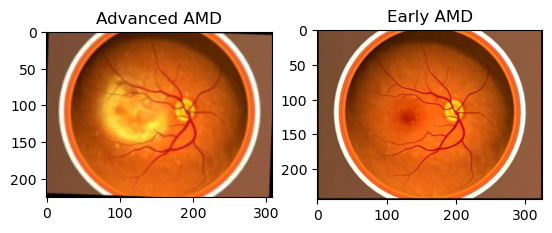

In [5]:
advanced_AMD_transformed = rotate(advanced_AMD, -shift_rotation)
advanced_AMD_transformed = rescale(advanced_AMD_transformed, 1 / shift_scale, channel_axis=-1)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(advanced_AMD_transformed)
axs[0].set_title('Advanced AMD')
axs[1].imshow(early_AMD)
axs[1].set_title('Early AMD')
plt.show()

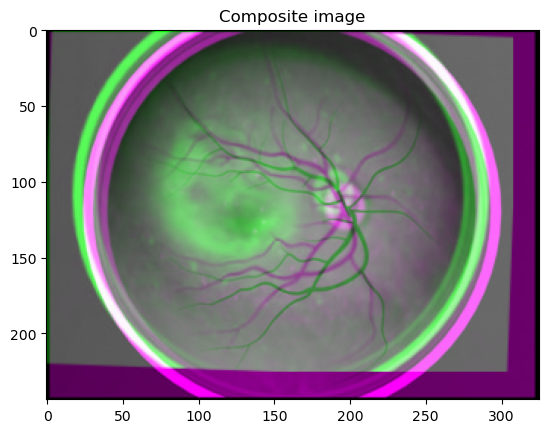

In [6]:
early_AMD_gray = cv2.cvtColor(early_AMD, cv2.COLOR_RGB2GRAY)
advanced_AMD_gray = cv2.cvtColor(np.uint8(advanced_AMD_transformed * 255), cv2.COLOR_RGB2GRAY)

stacked_AMD = np.dstack((early_AMD_gray,
                        np.pad(advanced_AMD_gray, pad_width=((0, early_AMD.shape[0] - advanced_AMD_gray.shape[0]), (0, early_AMD.shape[1] - advanced_AMD_gray.shape[1])), mode='constant', constant_values=0),
                        early_AMD_gray))

plt.imshow(stacked_AMD)
plt.title("Composite image")
plt.show()

Now, let's [recover translation difference](https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_translation.html#image-registration).

In [7]:
shift, error, phasediff = phase_cross_correlation(early_AMD, 
                                                  np.pad(advanced_AMD_transformed, pad_width=((0, early_AMD.shape[0] - advanced_AMD_transformed.shape[0]), (0, early_AMD.shape[1] - advanced_AMD_transformed.shape[1]), (0, 0)), mode='constant', constant_values=0))
shift_y = round(-shift[0])
shift_x = round(-shift[1])

print(f"""Offset taking 'early AMD' as reference image and 'advanced AMD' as moving image:\n
    translation [y, x] = {shift_y}, {shift_x}""")

Offset taking 'early AMD' as reference image and 'advanced AMD' as moving image:

    translation [y, x] = -10, -8


Apply transformations to "advanced_AMD_transformed".

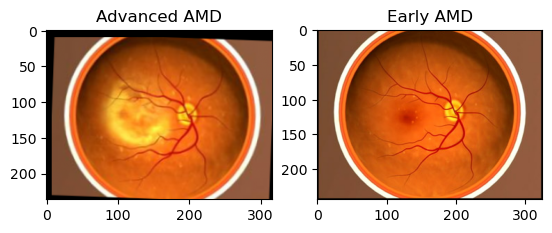

In [8]:
advanced_AMD_transformed = cv2.warpAffine(advanced_AMD_transformed, 
                                        np.float32([[1, 0, -shift_x], [0, 1, -shift_y]]), 
                                        (advanced_AMD_transformed.shape[1] + abs(shift_x), advanced_AMD_transformed.shape[0] + abs(shift_y)))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(advanced_AMD_transformed)
axs[0].set_title('Advanced AMD')
axs[1].imshow(early_AMD)
axs[1].set_title('Early AMD')
plt.show()

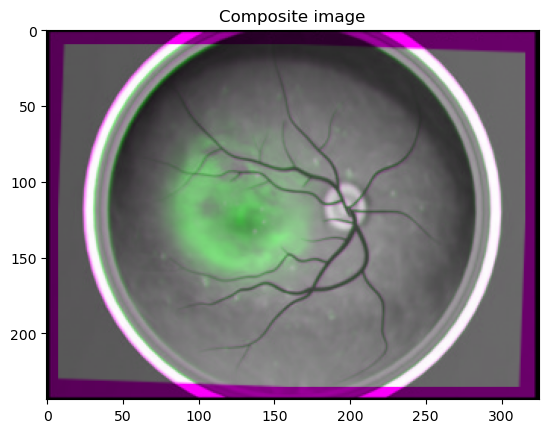

In [9]:
early_AMD_gray = cv2.cvtColor(early_AMD, cv2.COLOR_RGB2GRAY)
advanced_AMD_gray = cv2.cvtColor(np.uint8(advanced_AMD_transformed * 255), cv2.COLOR_RGB2GRAY)

stacked_AMD = np.dstack((early_AMD_gray,
                        np.pad(advanced_AMD_gray, pad_width=((0, early_AMD.shape[0] - advanced_AMD_gray.shape[0]), (0, early_AMD.shape[1] - advanced_AMD_gray.shape[1])), mode='constant', constant_values=0),
                        early_AMD_gray))

plt.imshow(stacked_AMD)
plt.title("Composite image")
plt.show()